In [18]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%cd '/content/drive/My Drive/RL/amalearn'

/content/drive/My Drive/RL/amalearn


In [20]:
!pwd

/content/drive/My Drive/RL/amalearn


In [21]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/RL/amalearn
  Attempting uninstall: amalearn
    Found existing installation: amalearn 0.1
    Can't uninstall 'amalearn'. No files were found to uninstall.
  Running setup.py develop for amalearn


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import math
from amalearn.agent import AgentBase
import csv
import pandas as pd

##Epsilon Greedy

In [23]:
class EpsilonGreedyAgent(AgentBase):
    def __init__(self, id, environment):
        super(EpsilonGreedyAgent, self).__init__(id, environment)
        
        self.counts = [0 for col in range(4)]
        self.values = [0.0 for col in range(4)]
        self.epsilon = 0.2
        self.alpha = 5
        self.beta = 2
        self.gamma = 5
       
  
    def take_action(self) -> (object, float, bool, object , np.ndarray ):
      available_actions = self.environment.available_actions()

      random_number = np.random.random_sample()
      if random_number >= self.epsilon:
        action = np.argmax(self.values)
      else:
        action = np.random.randint(available_actions)

  
      obs, r, d, i = self.environment.step(action)

      if r > 0 :
        r = math.pow(r, self.alpha)
      else:
        r = -self.gamma*math.pow(r, self.beta)       
      
      self.counts[action] = self.counts[action] + 1
      n = self.counts[action]
      value = self.values[action]
      new_value = ((n-1) / float(n)) * value + (1 / float(n)) * r
      self.values[action] = new_value
      # print(self.values)
      return obs, r, d, i
  


##UCB

In [24]:
class UCBAgent(AgentBase):
  def __init__(self, id, environment):
    super(UCBAgent, self).__init__(id, environment)
    
    self.counts = [ 0 for col in range(4) ]
    self.values = [ 0.0 for col in range(4) ]
    self.alpha = 5
    self.beta = 2
    self.gamma = 5
    
  def take_action(self) -> (object, float, bool, object , np.ndarray ): 
    UCB = [] 
    available_actions = self.environment.available_actions()
    
    total_counts = sum( self.counts )
    # select action
    for action in range(available_actions):    
      if self.counts[action] == 0:
        UCB.append(np.random.normal(1000,1))
      else:
        UCB.append(self.values[action] + 2 * math.sqrt( 2 * math.log(total_counts) ) / float( self.counts[action] )) 
    

    action=np.argmax(UCB)
    
    obs, r, d, i = self.environment.step(action)   
    
    if r > 0 :
      r = math.pow(r, self.alpha)
    else:
      r = -self.gamma*math.pow(r, self.beta)       

    # update
    self.counts[action] += 1
    n = self.counts[action]
    
    value = self.values[ action ]
    new_value = ( (n-1)* value + r ) / float(n)
    self.values[action] = new_value
    return obs, r, d, i
      

##GradientBased

In [25]:
def softmax(vector):
	e = vector 
	return e / e.sum()

In [26]:
class GradientBasedAgent(AgentBase):
  def __init__(self, id, environment):
    super(GradientBasedAgent, self).__init__(id, environment)
    self.alpha = 5
    self.beta = 2
    self.gamma = 5
    self.counts = [ 0 for col in range(4) ]
    
    self.reference_reward = 0
    self.H = [ 0.0 for col in range(4) ]

  def take_action(self) -> (object, float, bool, object , np.ndarray ):  
    available_actions = self.environment.available_actions()

    
    sum = math.exp(self.H[0])+math.exp(self.H[1])+math.exp(self.H[2])+math.exp(self.H[3])
    pi = [math.exp(self.H[0])/sum,math.exp(self.H[1])/sum,math.exp(self.H[2])/sum,math.exp(self.H[3])/sum]
  
    # pi = softmax(self.H) 
    
    action = np.random.choice(4,1,p=pi)
    
    obs, r, d, i = self.environment.step(action[0])   
  
    self.H[action[0]] += self.alpha*(r - self.reference_reward)*(1-pi[action[0]])
    
    for i in range(available_actions):
      if not i== action[0]:
        self.H[i] -= self.alpha*(r - self.reference_reward)* self.H[i]
    
    if r > 0 :
      r = math.pow(r, self.alpha)
    else:
      r = -self.gamma*math.pow(r, self.beta)
    
    self.counts[action[0]] += 1
    
    n = 0
    for i in range(len(self.counts)):
      n += self.counts[i]
    
    self.reference_reward = ( (n-1)* self.reference_reward + r ) / float(n)

    return obs, r, d, i
    
      

##Environment

In [27]:
import gym
from amalearn.environment import EnvironmentBase

class MyEnvironment(EnvironmentBase):
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        super(MyEnvironment, self).__init__(action_space, state_space, id, container)
        self.arms_rewards = rewards
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward()

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return
        

##REWARD

In [28]:
from amalearn.reward import RewardBase
import numpy as np

class GaussianReward(RewardBase):
    def __init__(self, mean, std):
        super(GaussianReward, self).__init__()
        self.mean = mean
        self.std = std

    def get_reward(self):
        return np.random.normal(loc=self.mean, scale=self.std)


class UniformReward(RewardBase):
    def __init__(self, low, high):
      super(UniformReward, self).__init__()
      self.low = low
      self.high = high

    def get_reward(self):
        return np.random.uniform(low=self.low, high=self.high, size=None)


In [29]:
# from amalearn.reward import GaussianReward
# from amalearn.reward import UniformReward

rewards = [0.0 for i in range(4)]
means = [6, 4, 3]
stds = [1, 2, 1]

rewards[0:3] = [GaussianReward(mean, std) for mean, std in zip(means, stds)]
random_number = np.random.random_sample()
if random_number >= 0.7:
  rewards[3] = GaussianReward(2, 2)
else:
  rewards[3] = UniformReward(-2, 1)

##RUN

In [30]:
env = MyEnvironment(rewards=rewards, episode_max_length = 1000, id = '1')
agent1 = EpsilonGreedyAgent('1', env)
agent2 = UCBAgent('2', env)
agent3 = GradientBasedAgent('3', env)

##EPSILONGREEDY_RUN

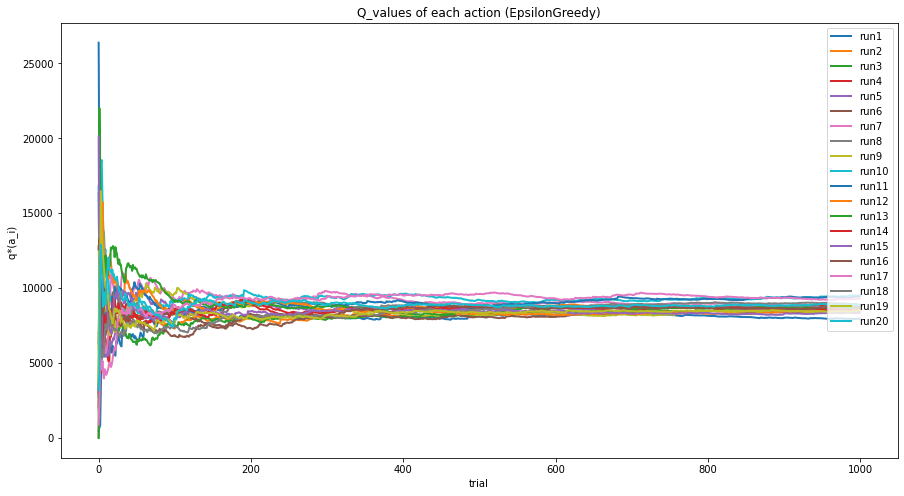

In [31]:
plt.figure(figsize=[15,8])
for i in range(20):
  AverageRewards = []
  r = 0
  
  for j in range(1,1001):
    observation, reward, done, info = agent1.take_action()
    r = (reward * 1/j) + r*(j-1)/j
    AverageRewards.append(r)

  
  plt.plot(AverageRewards,label = 'run' + str(i+1),linewidth=2)
  
plt.xlabel('trial')
plt.ylabel('q*(a_i) ')
plt.title('Q_values of each action (EpsilonGreedy)')
plt.legend(loc='upper right')
plt.show()

## UCB_RUN

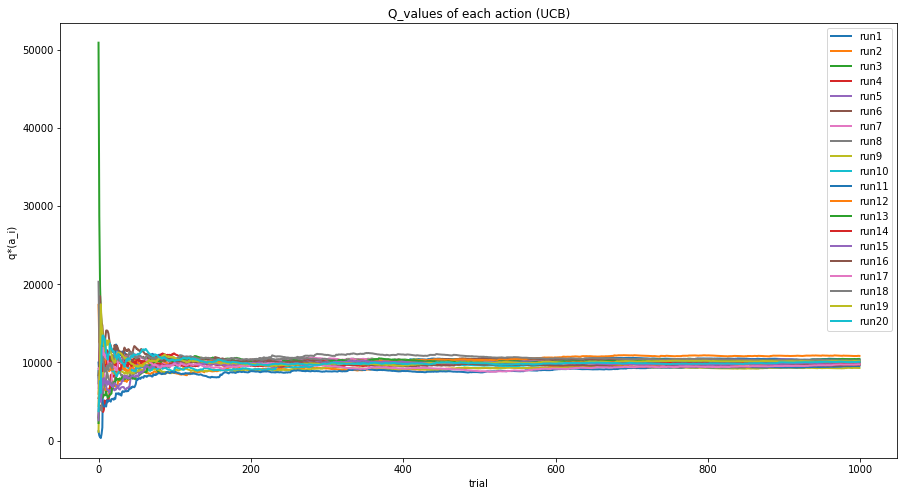

In [32]:
plt.figure(figsize=[15,8])
for i in range(20):
  AverageRewards = []
  r = 0
  
  for j in range(1,1001):
    observation, reward, done, info = agent2.take_action()
    r = (reward * 1/j) + r*(j-1)/j
    AverageRewards.append(r)

  
  plt.plot(AverageRewards,label = 'run' + str(i+1),linewidth=2)
  
plt.xlabel('trial')
plt.ylabel('q*(a_i) ')
plt.title('Q_values of each action (UCB)')
plt.legend(loc='upper right')
plt.show()

##GRADIENT_RUN

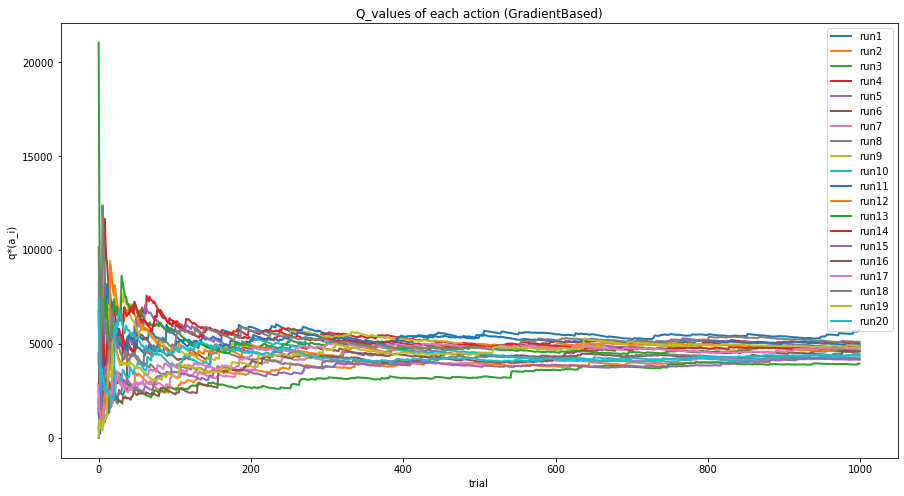

In [33]:
plt.figure(figsize=[15,8])
for i in range(20):
  AverageRewards = []
  r = 0
  
  for j in range(1,1001):
    observation, reward, done, info = agent3.take_action()
    r = (reward * 1/j) + r*(j-1)/j
    AverageRewards.append(r)

  
  plt.plot(AverageRewards,label = 'run' + str(i+1),linewidth=2)
  
plt.xlabel('trial')
plt.ylabel('q*(a_i) ')
plt.title('Q_values of each action (GradientBased)')
plt.legend(loc='upper right')
plt.show()

##REINFORCEMENT_COMPARISON

In [50]:
class ReinforcementComparisonAgent(AgentBase):
  def __init__(self, id, environment):
    super(ReinforcementComparisonAgent, self).__init__(id, environment)
    self.alpha =0.9
    self.beta = 0.1

  def take_action(self,alpha, beta, data) -> (object, float, bool, object , np.ndarray ):
    
    reference_reward = 0
    count = np.zeros(6)
    values = np.zeros(6)
    chosen_actions = []
    REGRET = []
    
    plt.figure()

    all_rewards = np.zeros(6)
    for s in range(498):
      reward_ = np.zeros(6)
      for t in range(6):
        reward_[t] = 2* float(data[s][t*2]) - float(data[s][t*2+1])
      all_rewards += reward_
    average_reward = all_rewards/498
    optimal_action = np.argmax(average_reward)
    # print(optimal_action)

    for i in range(data.shape[0]):
      H = np.zeros(6)
      reward = np.zeros(6)
      for j in range(int(data.shape[1]/2)):
        reward[j] = 2* float(data[i][j*2]) - float(data[i][j*2+1])
        H[j] += beta*(reward[j] - reference_reward)
    
      #softmax
      sum = math.exp(H[0])+math.exp(H[1])+math.exp(H[2])+math.exp(H[3])+math.exp(H[4])+math.exp(H[5])
      pi = [math.exp(H[0])/sum,math.exp(H[1])/sum,math.exp(H[2])/sum,math.exp(H[3])/sum,math.exp(H[4])/sum,math.exp(H[5])/sum]
      # pi = softmax(H) 
      action = np.random.choice(6,1,p=pi)
      # print("action",action)
    
      reference_reward +=  alpha*(reward[action] - reference_reward)
      count[action] +=1
      values[action] = reward[action]*(1/count[action]) + ((count[action]-1)/count[action])*values[action]
      
      
      regret = average_reward[optimal_action] - reference_reward
      # regret = 0
      # for k in range(6):
      #   regret += ((values[optimal_action] - values[k]) * count[k])
        # print(regret)
      REGRET.append(regret)
    print(len(REGRET))
    
    plt.plot(REGRET)
    plt.xlabel("trial")
    plt.ylabel("regret")
    plt.show()

In [54]:
data = pd.read_csv('Q3.csv')
opt, avg = utility(data)
print(opt, avg)
# agent4 = ReinforcementComparisonAgent('4', env)
# agent4.take_action(0.1,0.9, data)

KeyError: ignored